# Embeddings to test

* UMAP
* t-SNE
* Parametric UMAP (part of UMAP)
* DenseMap (part of UMAP)
* [PacMap](https://github.com/YingfanWang/PaCMAP)
* [TriMap](https://github.com/eamid/trimap)
* PCA
* Laplacian eigenmaps
* MDS
* Isomap
* [MDE](https://github.com/cvxgrp/pymde)
* [PHATE](https://github.com/KrishnaswamyLab/PHATE)
* ForceAtlas2
* dbMAP


# Experiments

* distance/distance-rank preservation with varying ```n_neighbors```, ```n_components``` and ```min_dist```, measured with Pearson's corr.
* hierarchical embedding: original -> 1000d -> 100d -> 2d
* negative test: does it magically create clusters? Test using a high dimensional Gaussian


Metrics:
* Spearman rank correlation between samples
* Pearson correlation of distances
* Distance correlation of distances
* Average Jaccard distance


In [1]:
%load_ext autoreload
%autoreload 1
%aimport omic_helpers
%matplotlib inline

from omic_helpers.graph import embedding as graph_embedding
from omic_helpers.graph import clustering as graph_clustering


from sklearn import datasets
from sklearn.preprocessing import StandardScaler, QuantileTransformer, RobustScaler, MinMaxScaler, FunctionTransformer
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

import umap
import pacmap
import trimap
import pymde
import dbmap

import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, KernelPCA, SparsePCA, NMF, FactorAnalysis
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness
from tqdm import tqdm

from scipy.sparse import csr_matrix

import gc

None
None


In [2]:
from sklearn.random_projection import GaussianRandomProjection as GPR
from sklearn.random_projection import johnson_lindenstrauss_min_dim as min_dim

from sklearn.kernel_approximation import Nystroem

In [3]:
def get_intra_sample_distances(X, how='euclidean'):
    if how == 'euclidean':  
        return distance.pdist(X)

- [x] 
 * [Sammon mapping](https://arxiv.org/pdf/2009.08136.pdf): 
 * landmark maximum variance unfolding 
 * Landmark MDS
 * [GSOM](https://github.com/CDAC-lab/pygsom/tree/master/gsom):  -> never mind this is a clustering method..
 * SMACOF
 * KernelPCA, PCA, SparsePCA
 * Factor Analysis
 * Isomap
 * Spectral Embedding/Laplacian eigenmap
 * UMAP
 * PacMap
 * t-SNE
 * dbMAP
 * Sammon
 * LLE
 * NMF
 * MDS
 * Trimap
 
- [ ]
 * [IVIS](https://github.com/beringresearch/ivis): [paper](https://www.nature.com/articles/s41598-019-45301-0)
 * [FactorizedEmbeddings](https://github.com/TrofimovAssya/FactorizedEmbeddings): [paper](https://academic.oup.com/bioinformatics/article/36/Supplement_1/i417/5870511)
 * [Diffeomap](): diffeomorphic dimensionality reduction Diffeomap
 * HOPE: karateclub
    * custom autoencoder 
    * RankVisu
    * FastMap MDS: https://github.com/shawn-davis/FastMapy
    * MetricMap
    * SparseMap: https://github.com/vene/sparsemap
    * growing curvilinear component analysis
    * curvilinear distance analysis
    * autoencoder NeuroScale
    * PHATE
    * GPLVM
    * FA
    * Nonlinear PCA
    * SDNE 
    * GCN
    * Graph Factorisation
    * [opt-SNE](https://github.com/omiq-ai/Multicore-opt-SNE): 
    *  Poincare embedding : https://github.com/facebookresearch/poincare-embeddings
    * NN-graph/Parametric UMAP -> GraphSage/Node2Vec/etc.. see NetworkX and karateclub!
    * https://github.com/benedekrozemberczki/karateclub
    * [GEM benchmark](https://github.com/palash1992/GEM-Benchmark), [GEM git](https://github.com/palash1992/GEM), [GEM paper](https://www.sciencedirect.com/science/article/pii/S0950705118301540)



# testsuite
* distance preservation, 
* trustworthiness, 
* topology preservation (https://github.com/scikit-tda, https://github.com/giotto-ai/giotto-tda)


# Ideas

* Use Bolt to accelerate NN-search: https://github.com/dblalock/bolt
* benchmarks: https://www.nature.com/articles/s41598-019-45301-0
* add custom encoder: https://discuss.pytorch.org/t/extracting-reduced-dimension-data-from-autoencoder-in-pytorch/56581


# Test on genomic data

In [4]:
# RNA expression data from ~1000 lung cancer patients
RNAex = pd.read_feather("/media/bramiozo/DATA-FAST/genetic_expression/lung_cancer_2021/TCGA/Lung/Lung_RNAex.feather")
RNAex.set_index('index', inplace=True)
RNAex = RNAex.loc[:, RNAex.columns[RNAex.var(axis=0)>0].values]

In [5]:
min_dim(RNAex.shape[0], eps=0.75)

200

[]

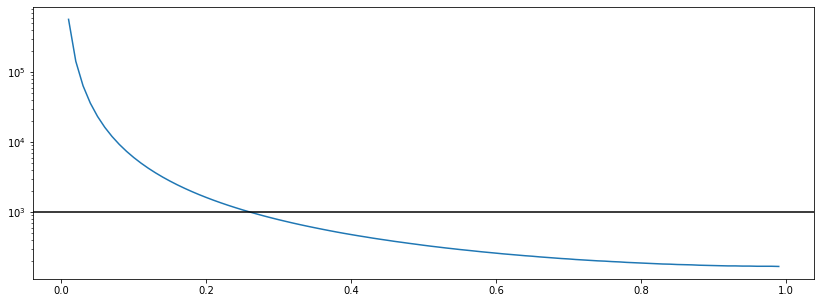

In [6]:
fig, ax = plt.subplots(figsize=(14,5))
eps_range = np.arange(1, 100, 1)/100
min_dims = [min_dim(RNAex.shape[0], eps=_eps) for _eps in eps_range]
sns.lineplot(eps_range, min_dims, ax=ax)
ax.axhline(1000, color='black')
ax.semilogy()

In [161]:
num_samples = 1000
sample_size = 250
sample_selection = np.random.randint(0,num_samples, sample_size)
n_landmarks = 75

n_n = 47
reduce_dim = 3
scaler = StandardScaler()
embedder_type = 'SMACOF'


embedder = {}
embedder['nystrom'] = Nystroem(kernel='rbf', n_components=reduce_dim, random_state=1234)
embedder['umap'] = umap.UMAP(n_components=reduce_dim, densmap=False, metric='euclidean',
                             n_neighbors=n_n, min_dist=0., disconnection_distance=None)
embedder['trimap'] = trimap.TRIMAP(n_dims=reduce_dim, n_iters=2500, lr=0.15);
embedder['pacmap'] = pacmap.PaCMAP(n_dims=reduce_dim, n_neighbors=n_n)
embedder['SpectralEmbedding'] = SpectralEmbedding(n_components=reduce_dim, n_neighbors=n_n)
embedder['Isomap'] = Isomap(n_components=reduce_dim)
embedder['MDS'] = MDS(n_components=reduce_dim, metric='euclidean')
embedder['KernelPCA'] = KernelPCA(n_components=reduce_dim, kernel='sigmoid')
embedder['PCA'] = PCA(n_components=reduce_dim)
embedder['SparsePCA'] = SparsePCA(n_components=reduce_dim, alpha=0.0001, n_jobs=8)
embedder['FA'] = FactorAnalysis(n_components=reduce_dim, max_iter=1000)
embedder['dbmap'] = dbmap.diffusion.Diffusor(n_components=120, ann_dist='euclidean')
embedder['LLE'] = LLE(n_components=reduce_dim, n_neighbors=n_n, method='ltsa')
embedder['NMF'] = NMF(n_components=reduce_dim, max_iter=10000)
embedder['TSNE'] = TSNE(n_components=3, perplexity=50)
embedder['Sammon'] = graph_embedding.Sammon(n_components=reduce_dim, n_neighbors=n_n,
                                            max_iterations=250, learning_rate=0.25, init_type='PCA')
embedder['MVU'] = graph_embedding.MaximumVarianceUnfolding(n_components=2, n_neighbors=n_n)
embedder['LMVU'] = graph_embedding.LandmarkMaximumVarianceUnfolding(n_components=reduce_dim, 
                                                                     n_neighbors=n_n, 
                                                                     n_landmarks=n_landmarks)
embedder['LMDS'] = graph_embedding.LandmarkMultiDimensionalScaling(n_components=reduce_dim,
                                                                     n_landmarks=n_landmarks)
embedder['GPR'] = GPR(n_components=reduce_dim, random_state=3231, eps=0.8)


TRIMAP(n_inliers=10, n_outliers=5, n_random=5, distance=euclidean, lr=0.15, n_iters=2500, weight_adj=500.0, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)


In [162]:
if embedder_type == 'dbmap':
    pipe = Pipeline([('scaler', scaler), 
                     ('prepmap', embedder['dbmap']), 
                     ('reducer', embedder['umap'])])
    tts = embedder['dbmap'].fit_transform(RNAex)
    RNAembedded =np.array(pipe.fit_transform(tts))
elif embedder_type == 'NMF':    
    nonnegger = lambda x: x + 2*np.abs(np.min(x, axis=0))
    nonnegger_F = FunctionTransformer(func=nonnegger)

    pipe = Pipeline([('scaler', scaler), 
                     ('nngr', nonnegger_F), 
                     ('reducer', embedder['NMF'])])
    RNAembedded = pipe.fit_transform(RNAex)
elif embedder_type == 'SMACOF':
    try:
        dissimilarities;
    except NameError:
        # np.abs(np.log(similarities))
        dissimilarities = distance.squareform(distance.pdist(RNAex.values, metric='euclidean'))
    RNAembedded = smacof(dissimilarities, n_components=reduce_dim, max_iter=300, eps=1e-3, n_jobs=4)[0]
else:
    pipe = Pipeline([('scaler', scaler), 
                     ('reducer', embedder[embedder_type])])
    RNAembedded = pipe.fit_transform(RNAex)

{'dataset': 'RNAex', 'corr': 0.7708866786095963}
0.8790660949305982


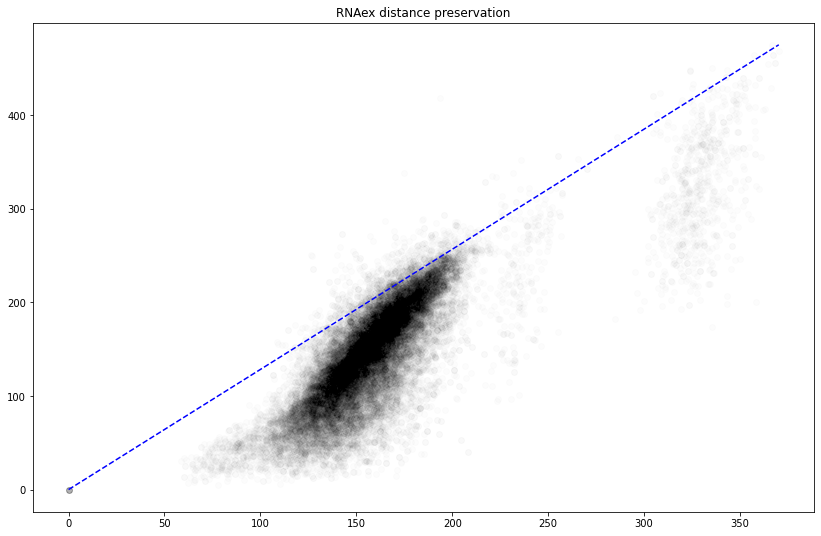

In [163]:
dist_or = get_intra_sample_distances(RNAex.iloc[sample_selection,:])
dist_emb = get_intra_sample_distances(RNAembedded[sample_selection,:])

dists = {'d_or': dist_or, 'd_emb': dist_emb}
dist_preservation_overall = {'dataset': 'RNAex', 
                          'corr':dcor.distance_correlation(dist_or, dist_emb)}

fig, ax = plt.subplots(figsize=(14,9))
ax.scatter(x=dists['d_or'], y=dists['d_emb'], color='black', alpha=0.01)
mx,my = max(dists['d_or']), max(dists['d_emb'])
ax.plot([0,mx], [0, my], ls='--', c='blue')
ax.set_title('RNAex distance preservation')

print(dist_preservation_overall)
print(trustworthiness(RNAex, RNAembedded))
# topology preservation?

In [164]:
plot_df = pd.DataFrame(data=RNAembedded, columns=['d'+'_'+str(i) for i in range(reduce_dim)], index=RNAex.index)
meta = pd.read_feather("/media/bramiozo/DATA-FAST/genetic_expression/lung_cancer_2021/TCGA/Lung/Lung_meta.feather")
meta.set_index('SampleID', inplace=True)
plot_df = plot_df.join(meta[['Diagnosis', 'Response']], how='left')

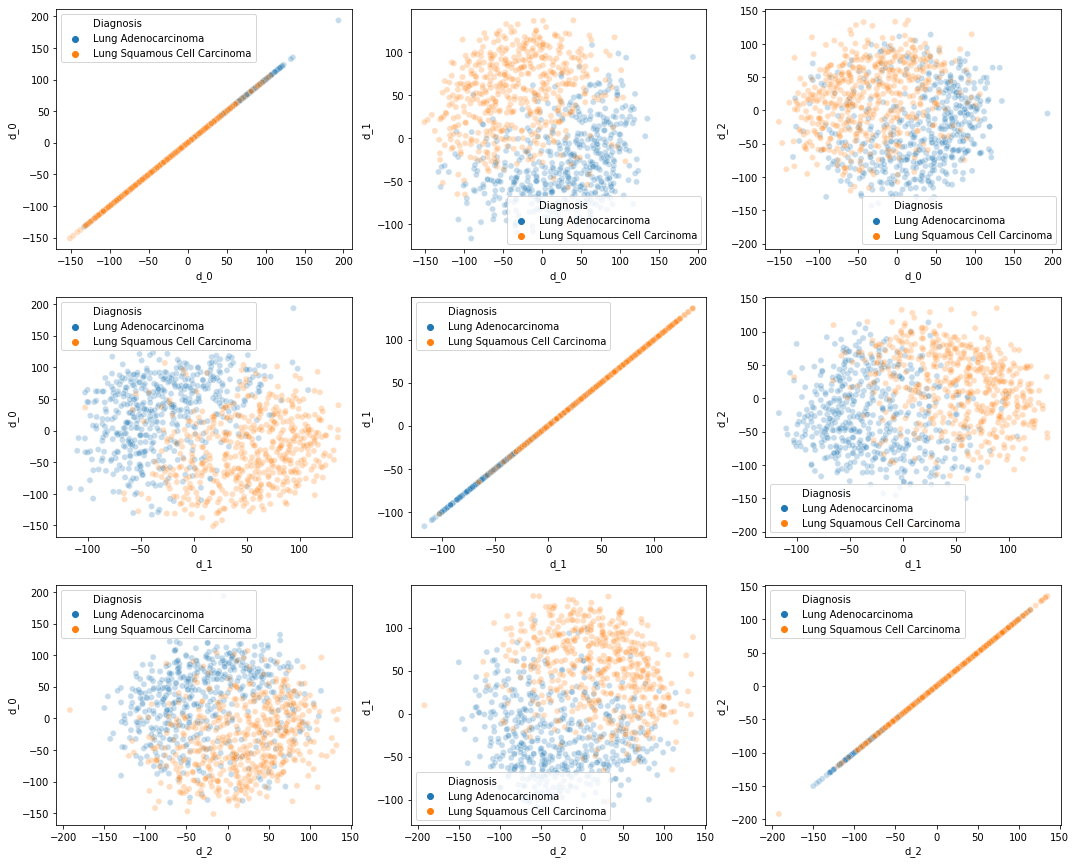

In [165]:
reduce_dim = min([6, reduce_dim])
num_rows = int(np.ceil((reduce_dim)**2/3))
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
for ki in range(reduce_dim):
    for kj in range(reduce_dim): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            sns.scatterplot(data=plot_df, x='d_'+str(ki), y='d_'+str(kj), ax=ax[i,j], hue='Diagnosis', alpha=0.25)
        else:
            sns.scatterplot(data=plot_df, x='d_'+str(ki), y='d_'+str(kj), ax=ax[k], hue='Diagnosis', alpha=0.25)
        k += 1

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch import Tensor
from torchvision import datasets

In [8]:
# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(f"Using: {device}")

Using: cpu


In [9]:
class DenseEncoder(nn.Module):
    def __init__(self, in_features, out_features, layer_sizes):
        super(DenseEncoder, self).__init__()
        
        layer_sizes = [in_features] + layer_sizes
        
        self.seq= nn.Sequential()       
        for idx in range(0, len(layer_sizes)-1):
            self.seq.add_module('ENC_fc_'+str(idx), nn.Linear(in_features=layer_sizes[idx], 
                                                              out_features=layer_sizes[idx+1]))
            self.seq.add_module('ENC_relu_'+str(idx), nn.ReLU())
        self.seq.add_module('ENC_fcF', nn.Linear(in_features=layer_sizes[-1], out_features=out_features))
        
    def forward(self, x):
        return self.seq(x) 

class DenseDecoder(nn.Module):
    def __init__(self, in_features, out_features, layer_sizes):
        super(DenseDecoder, self).__init__()
        
        layer_sizes = list(reversed(layer_sizes))
        layer_sizes = [out_features] + layer_sizes
        
        self.seq= nn.Sequential()
        for idx in range(0, len(layer_sizes)-1):
            self.seq.add_module('DEC_fc_'+str(idx), nn.Linear(in_features=layer_sizes[idx], 
                                                              out_features=layer_sizes[idx+1]))
            self.seq.add_module('DEC_relu_'+str(idx), nn.ReLU())
        self.seq.add_module('DEC_fcF', nn.Linear(in_features=layer_sizes[-1], out_features=in_features))
        
    def forward(self, x):
        return F.selu(self.seq(x))  
    
class DenseAE(nn.Module):
    
    def __init__(self, **kwargs):
        super(DenseAE, self).__init__()
        self.encoder = DenseEncoder(in_features=kwargs['in_features'], 
                                    out_features=kwargs['out_features'],
                                    layer_sizes=kwargs['layer_sizes'])
        self.decoder = DenseDecoder(in_features=kwargs['in_features'], 
                                    out_features=kwargs['out_features'],
                                    layer_sizes=kwargs['layer_sizes'])

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [10]:
class ConvEncoder(nn.Module):
    def __init__(self, in_features, out_features, layer_sizes):
        super(ConvEncoder, self).__init__()
        
        self.seq = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8, stride=4, padding=0, 
                      bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0, 
                      bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=out_features, kernel_size=3, stride=1, padding=0, 
                      bias=True),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.seq(x) 

class ConvDecoder(nn.Module):
    def __init__(self, in_features, out_features, layer_sizes):
        super(ConvDecoder, self).__init__()
        
        self.seq = nn.Sequential(
            nn.ConvTranspose1d(in_channels=out_features, out_channels=64, kernel_size=3, stride=1, padding=0, 
                               bias=False),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0, 
                               bias=False),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=8, stride=4, padding=0, 
                               bias=True)
        )
        
    def forward(self, x):
        return self.seq(x) 
    
class ConvAE(nn.Module):
    
    def __init__(self, **kwargs):
        super(ConvAE, self).__init__()
        self.encoder = ConvEncoder(in_features=kwargs['in_features'], 
                                    out_features=kwargs['out_features'],
                                    layer_sizes=kwargs['layer_sizes'])
        self.decoder = ConvDecoder(in_features=kwargs['in_features'], 
                                    out_features=kwargs['out_features'],
                                    layer_sizes=kwargs['layer_sizes'])

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [11]:
class MixedColumnarDataset(Dataset):
    """Dataset class for column dataset.
    Args:
       cats (list of str): List of the name of columns contain
                           categorical variables.
       conts (list of str): List of the name of columns which 
                           contain continuous variables.
       y (Tensor, optional): Target variables.
    """
    def __init__(self, df, cat_flds):       
        conts = [c.values for n,c in df.items()]
        
        n = len(conts[0])
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.len = len(df)
        
    def __len__(self): 
        return self.len   
    
    def __getitem__(self, idx):
        return self.conts[idx]

In [21]:
RNAex_normalised = pd.DataFrame(data=StandardScaler().fit_transform(RNAex.values), 
                                columns=RNAex.columns.tolist())
dense_net = DenseAE(in_features=RNAex.shape[1], out_features=8, layer_sizes=[32,16])
dense_net.to(device)

conv_net = ConvAE(in_features=RNAex.shape[1], out_features=8, layer_sizes=[32,16])
conv_net.to(device)



NUM_EPOCHS = 10
LEARNING_RATE = 1e-2

criterion = nn.MSELoss()
#criterion = nn.binary_cross_entropy()
conv_optimizer = optim.Adam(conv_net.parameters(), lr=LEARNING_RATE)
dense_optimizer = optim.Adam(dense_net.parameters(), lr=LEARNING_RATE)

In [19]:
train_dl = DataLoader(MixedColumnarDataset(RNAex_normalised, []), batch_size=1)

In [22]:
dense_net

DenseAE(
  (encoder): DenseEncoder(
    (seq): Sequential(
      (ENC_fc_0): Linear(in_features=58324, out_features=32, bias=True)
      (ENC_relu_0): ReLU()
      (ENC_fc_1): Linear(in_features=32, out_features=16, bias=True)
      (ENC_relu_1): ReLU()
      (ENC_fcF): Linear(in_features=16, out_features=8, bias=True)
    )
  )
  (decoder): DenseDecoder(
    (seq): Sequential(
      (DEC_fc_0): Linear(in_features=8, out_features=16, bias=True)
      (DEC_relu_0): ReLU()
      (DEC_fc_1): Linear(in_features=16, out_features=32, bias=True)
      (DEC_relu_1): ReLU()
      (DEC_fcF): Linear(in_features=32, out_features=58324, bias=True)
    )
  )
)

In [26]:
outputs = None
def get_embeddings(model, x):
    return model.encoder.forward(Tensor(x)).detach().numpy()

def train(net, trainloader, NUM_EPOCHS, ntype='conv'):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            if ntype=='conv':
                dataTensor = Tensor(data).unsqueeze(0)
                conv_optimizer.zero_grad()            
                outputs = conv_net(dataTensor)
                loss = criterion(outputs, dataTensor)
            else:
                dense_optimizer.zero_grad()            
                outputs = dense_net(data)
                loss = criterion(outputs, data)                
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print(f"-------------Train loss: {loss}, epoch: {epoch}")

    return train_loss

In [28]:
# train the network
train_loss = train(conv_net, train_dl, NUM_EPOCHS, ntype='conv')

-------------Train loss: 1.0256518086410304, epoch: 0
-------------Train loss: 1.0256518086410304, epoch: 1
-------------Train loss: 1.0256518086410304, epoch: 2


KeyboardInterrupt: 

In [17]:
embs = get_embeddings(conv_net, RNAex_normalised.values)

RuntimeError: Expected 3-dimensional input for 3-dimensional weight [32, 1, 8], but got 2-dimensional input of size [1135, 58324] instead

In [ ]:
plot_df = pd.DataFrame(data=embs, columns=['d_'+str(i) for i in range(reduce_dim)])
sns.scatterplot(data=plot_df, x='d_1', y='d_2')

<module 'torchvision.datasets.mnist' from '/media/bramiozo/home/bramiozo/VIRTUALENVS/long/lib/python3.8/site-packages/torchvision/datasets/mnist.py'>

The distance correlation/preservation and the trustworthiness metrics are not suitable metrics to qualify embeddings as they cannot distinguish between neighborhoods in the original space. Even if points are projected randomly they can have similar distances in lower dimensional space, in fact the higher the dimensionality of the embeddeds space the more possibilities there are to randomly obtain similar intra-point distances.

We would expect that if we increase the embedded dimensions we get closer to the performance of random projections in terms of intra-distance preservations.

# Test on CELLDYN data

# Semi-supervised UMAP

The main flavor is to add labels for the different clusters we know we want to 
see. This can be based on a clustering on a sample set of the original data (perhaps also a selection of features).

# Parametric UMAP

* Create nearest-neighbor graph with fuzzy simplicials
* Apply graph embedder

# Anchored embedding

# Distance preserving embedding

* Siamese twins networks
* distance as outcome
* pairs as input

The method IVIS seems to use this idea.

# Ranking based embedder

# Multi-patch UMAP

The core assumption of UMAP is that all points lie on the same manifold. What if we split our data in dense patches prior to the creation of the fuzzy simplicials? 

To make this tractable this split should be computationally in-expensive. One way to go about is to treat overlapping regions with a sufficient number of samples as patches. The embeddings associated with these patches can later be combined.



# Multi-sample UMAP


* $N$ sampled UMAP embedders with/without minimal perturbations
* aligned using Procrustes
* uniform scaling
* concensus distance determination

# Landmarkbased embeddings coupled to sparse exemplar finders

Instead of random landmarks we can use exemplars based on 
* points closest to centroids
* exemplars based on e.g. affinity propagation